In [11]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

env = gym.make("CartPole-v1")

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda


In [12]:
env = gym.make("CartPole-v1")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [13]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


# class ReplayMemory(object):

#     def __init__(self, capacity):
#         self.memory = deque([], maxlen=capacity)

#     def push(self, *args):
#         """Save a transition"""
#         self.memory.append(Transition(*args))

#     def sample(self, batch_size):
#         return random.sample(self.memory, batch_size)

#     def __len__(self):
#         return len(self.memory)
    
import numpy as np

class PrioritizedReplayMemory(object):
    def __init__(self, capacity, alpha=0.6):
        self.alpha = alpha
        self.capacity = capacity
        self.memory = []
        self.priorities = np.zeros((capacity,), dtype=np.float32)
        self.position = 0

    def push(self, *args):
        max_priority = self.priorities.max() if self.memory else 1.0
        if len(self.memory) < self.capacity:
            self.memory.append(Transition(*args))
        else:
            self.memory[self.position] = Transition(*args)
        self.priorities[self.position] = max_priority
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size, beta=0.4):
        if len(self.memory) == self.capacity:
            priorities = self.priorities
        else:
            priorities = self.priorities[:self.position]
        probabilities = priorities ** self.alpha
        probabilities /= probabilities.sum()

        indices = np.random.choice(len(self.memory), batch_size, p=probabilities)
        transitions = [self.memory[idx] for idx in indices]

        total = len(self.memory)
        weights = (total * probabilities[indices]) ** (-beta)
        weights /= weights.max()
        weights = torch.tensor(weights, device=device, dtype=torch.float32)

        batch = Transition(*zip(*transitions))
        return batch, weights, indices

    def update_priorities(self, batch_indices, batch_priorities):
        for idx, priority in zip(batch_indices, batch_priorities):
            self.priorities[idx] = priority

    def __len__(self):
        return len(self.memory)



In [14]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.relu(self.layer3(x))
        return self.layer4(x)



In [15]:
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4
n_actions = env.action_space.n
state, info = env.reset()
n_observations = len(state)
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())
# optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
optimizer = optim.RMSprop(policy_net.parameters(), lr=LR)
# memory = ReplayMemory(10000)
memory = PrioritizedReplayMemory(10000)
steps_done = 0


In [16]:
episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [17]:
def select_action(state):
    global steps_done
    eps_threshold = EPS_END + (EPS_START - EPS_END) * max(0.0, (EPS_DECAY - steps_done) / EPS_DECAY)
    steps_done += 1
    if random.random() > eps_threshold:
        with torch.no_grad():
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    batch, weights, indices = memory.sample(BATCH_SIZE)
    
    # Compute a mask of non-final states and concatenate the batch elements
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)
    
    # Compute Q(s_t, a)
    state_action_values = policy_net(state_batch).gather(1, action_batch)
    
    # Compute V(s_{t+1}) for all next states
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss(reduction='none')
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
    prios = loss + 1e-5
    loss = (loss * weights.unsqueeze(1)).mean()

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

    memory.update_priorities(indices, prios.detach().cpu().numpy())

def optimize_reward(state, reward, done):
    x, x_dot, theta, theta_dot = state
    r1 = (env.env.x_threshold - abs(x)) / env.env.x_threshold - 0.8
    r2 = (env.env.theta_threshold_radians - abs(theta)) / env.env.theta_threshold_radians - 0.5
    reward = r1 + r2
    if done:
        reward -= 10
    return reward



In [18]:
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 500

import time
start_time = time.time()

success_count = 0  # 记录连续成功达到500步的次数

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    cumulative_reward = 0
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())

        reward = optimize_reward(observation, reward, terminated)
        cumulative_reward += reward
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)
        # Store the transition in memory
        memory.push(state, action, next_state, reward)
        
        state = next_state
        
        optimize_model()
        
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key] * TAU + target_net_state_dict[key] * (1 - TAU)
        target_net.load_state_dict(target_net_state_dict)
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            if truncated:
                success_count += 1
            else:
                success_count = 0
            break
    print(f'Episode {i_episode + 1}, Cumulative Reward: {cumulative_reward}, success_count: {success_count}')
    if success_count >= 10:
        break

end_time = time.time()
print('Complete')
print('The training time is ', (end_time - start_time), 's')

Episode 55, Cumulative Reward: 217.83108779885777, success_count: 10
Complete
The training time is  59.967573165893555 s


<Figure size 640x480 with 0 Axes>

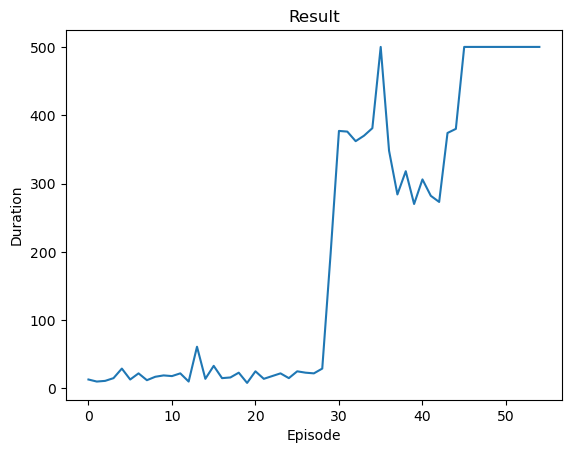

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [19]:
plot_durations(show_result=True)
plt.ioff()
plt.show()